# Caudal Horn QTL Analysis of BC

##### *Date: Aug 2025*
##### *yk2840@columbia.edu*


This notebook contains the QTL and ancestry anaylses for BCs related to Figure 2.

rQTL marker genotype data is available upon request. Corresponding author: pa2543@columbia.edu 


In [1]:
# This code is related to importing the MSG output into R for rQTL. 
# https://github.com/dstern/read_cross_msg

read.cross.msg <- function(file.csv,ancfile.par2, phenofile, ancfile.par1=NULL) {
   require(qtl)
   
   if(is.null(ancfile.par1)) backcross <- TRUE
   else backcross <- FALSE##DLS added to indicate that backcross is false if 

   prob.AA <- as.matrix(read.table(ancfile.par2, header=TRUE, row.names=1,
                                   as.is=TRUE, check.names=FALSE))
  
   if(backcross) { 
   	   genotypes <- c("BB","BA","AA") ; alleles <- c("A","B")#Note that BB reflects backcross to parent 2 in our cross. We treat as "AA" here.
   	      	   
   	}
   else   {
       genotypes <- c("AA","AB","BB") ; alleles <- c("A","B")
       prob.BB <- as.matrix(read.table(ancfile.par1, header=TRUE, row.names=1,
                                   as.is=TRUE, check.names=FALSE))
                                   stopifnot(dim(prob.BB) == dim(prob.AA))
       } 
  message("start read")
  cross <- read.cross(format="csvs", genfile=file.csv, phefile = phenofile,genotypes=genotypes,alleles =alleles,
				estimate.map = FALSE
					  )
  message("finish read")
  cross <- calc.genoprob(cross)
     indivs <- rownames(prob.AA)
     markers <- colnames(prob.AA)
     col.labels <- strsplit(markers, ":")
     contigs <- sapply(col.labels, "[", 1)
     contigs.f <- factor(contigs)
     bp <- as.integer(sapply(col.labels, "[", 2))
     split.bp<-split(bp,f=contigs.f)
     split.markers<-split(markers,f=contigs.f)

   split.probs <- function(p) {
       p <- split(as.data.frame(t(p)), f=contigs.f)
       lapply(lapply(p, as.matrix), t)
   }
   prob.AA <- split.probs(prob.AA)
   if(backcross) {
       prob.AB <- lapply(prob.AA, function(p) 1-p)
       bindfun <- function(pAA, pAB, markers) {
           p <- array(dim=c(dim(pAA), 2),
                      dimnames=list(indivs, markers, genotypes[1:2]))
           p[,,1] <- pAA
           p[,,2] <- pAB
           p
       }
       probs <- mapply(bindfun, prob.AA, prob.AB, split(markers, f=contigs.f), SIMPLIFY=FALSE)
   }
   else {
       prob.BB <- split.probs(prob.BB)
       prob.AB <- mapply(function(pAA, pBB) 1 - pAA - pBB, prob.AA, prob.BB, SIMPLIFY=FALSE)
       bindfun <- function(pAA, pAB, pBB, markers) {
           p <- array(dim=c(dim(pAA), 3),
                      dimnames=list(indivs, markers, genotypes))
           p[,,1] <- pAA
           p[,,2] <- pAB
           p[,,3] <- pBB
           p
       }
       #recall prob.AA is par2
       probs <- mapply(bindfun, prob.BB, prob.AB, prob.AA, split(markers, f=contigs.f), SIMPLIFY=FALSE)


   }

   step <- 0 ; off.end <- 0 ; stepwidth <- "fixed"

   for(contig in levels(contigs.f)) {
       
       if(backcross) 
	   cross$geno[[contig]]$prob <- probs[[contig]]
	   	   
       else {
 	   	   #check contig, if not X, just proceed
 	       if (contig != 'X')
                   cross$geno[[contig]]$prob <- probs[[contig]]
               else
                   #grab only probs[,,1] & probs[,,3]
                   cross$geno[[contig]]$prob <- probs[[contig]][,,c(1,3)]
 	   	   
             }

       contig.map<-as.numeric(split.bp[[contig]])
       attr(contig.map,"names") <-split.markers[[contig]]
       attr(cross$geno[[contig]]$prob, "map") <- contig.map
       attr(cross$geno[[contig]]$prob, "error.prob") <- 1e-04 #fixed this prob slot in v. 1.5, now can run scantwo
       attr(cross$geno[[contig]]$prob, "step") <- step
       attr(cross$geno[[contig]]$prob, "off.end") <- off.end
       attr(cross$geno[[contig]]$prob, "map.function") <- "haldane" 
       attr(cross$geno[[contig]]$prob, "stepwidth") <- stepwidth
       
   }
   cross
}


#cross <- read.cross.msg("Whole_genome_thinned_concatenated_geno.sorted.pulled.converted.thinned.csv",
#                    "Whole_genome_thinned_concatenated_par2.tsv.sorted.pulled.converted.thinned.f2_rqtl",
#                    "F2_pheno.csv.sorted",
#                    ancfile.par1="Whole_genome_thinned_concatenated_par1.tsv.sorted.pulled.converted.thinned.f2_rqtl")
#save(cross, file = "F2_rqtl.Rdata")

## Required Libraries

In [2]:
library(dplyr)
library(stringr)
library(ggplot2)
library(reshape2)
library(qtl)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Caudal Horn Lengths across Species

### Figure 2A Plot

In [3]:
setwd("./data_for_github/Fig2/")
df<-read.csv(file="Fig2A_caudalhorn_lengths_2025.csv")

df$Species <- factor(df$Species, levels = c("B.mori\n(p50T)", "BC1", "F1", "F2", "B.mandarina\n(Sakado)"))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“The dot-dot notation (`..y..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(y)` instead.”


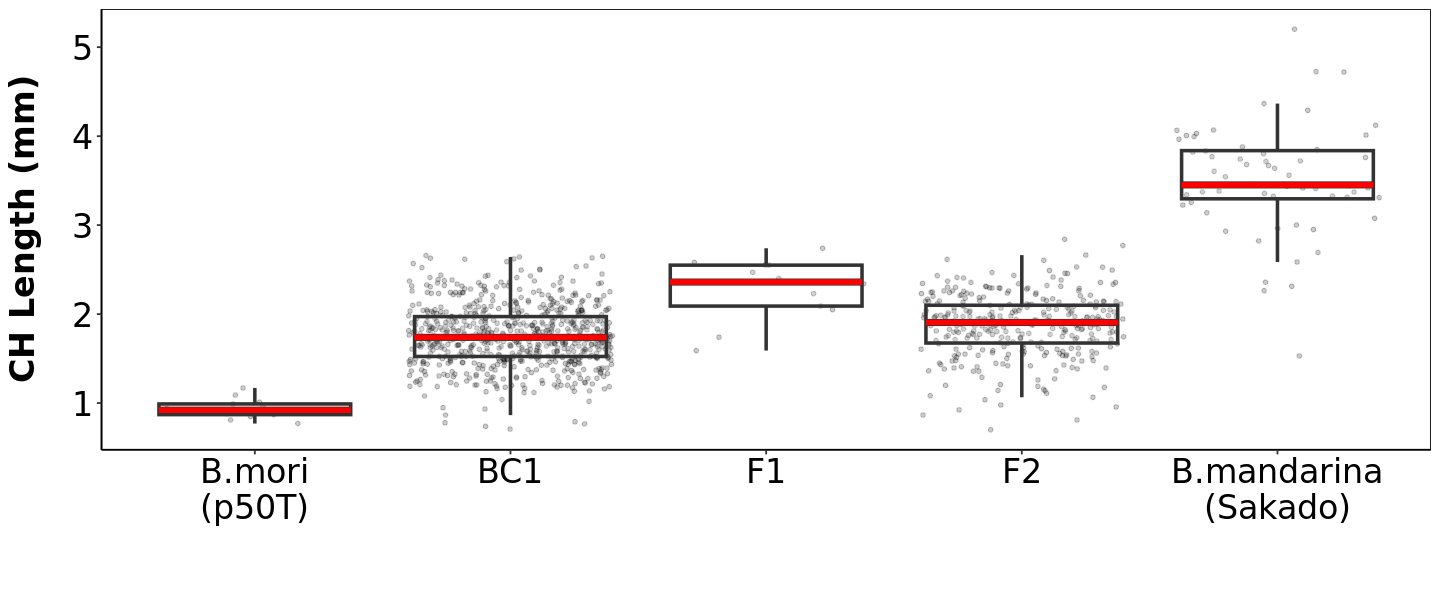

In [4]:
options(repr.plot.width=12, repr.plot.height=5)

figa<-ggplot(df, aes(x = Species, y = length)) +
  geom_jitter(size=1,alpha = 0.2) +
  geom_boxplot(size = 1, alpha=0.1, outlier.shape=NA) +
  stat_summary(fun = median, geom = "errorbar", 
               aes(ymax = ..y.., ymin = ..y..), 
               width = 0.75, color = "red", size = 1.5) +  
  theme_bw() +
  theme(
    axis.line = element_line(colour = "black"),
    #aspect.ratio = 1,
    panel.border = element_rect(colour = "black", size = 0.5),
    text = element_text(size = 12),
    legend.position = "bottom",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.title.y = element_text(vjust = 1, face = "bold", size = 20, margin = margin(10, 20, 10, 0), colour = "black"),
    axis.title.x = element_text(vjust = 1, margin = margin(10, 20, 10, 0), face = "bold", size = 20, colour = "black"),
    axis.text.x = element_text(size = 20, colour = "black"),
    axis.text.y = element_text(size = 20, colour = "black"),
    plot.title = element_text(face = "bold")
  ) +
  labs(x = "", y = "CH Length (mm)")
print(figa)

# QTL Analyses (Fig2B-D)

#### Load BC data

In [5]:
# Load Cross Data
load("BC_rQTL.RData")
load("BC_rQTL_perm.RData")

# Load Ancestry Calcs
ancestry<-read.csv("BC_ancestry_summary_per_chrom.csv")
# Load chromosome info
chr_regions<-read.delim("./B_mori_50T_assembly/Bomo_genome_assembly_chr_only.fa.fai", header=FALSE)


####  Calculate Ancestry excluding BC QTL-bearing Chromosomes

In [6]:
ancestry<-ancestry[-which(ancestry$Chromosome %in% c("Chr4", "Chr5", "Chr7", "Chr9", "Chr10", "Chr21", "Chr25", "Chr26")),]
ancestry_summary <- ancestry %>%
  group_by(Individual) %>%
  summarise(
    Total_AA = sum(AA_Length, na.rm = TRUE),
    Total_AB = sum(AB_Length, na.rm = TRUE),
    Total_BB = sum(BB_Length, na.rm = TRUE)
  )
ancestry_summary$Total<-ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB * 2 + ancestry_summary$Total_BB * 2 
ancestry_summary$Prop_A<-(ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB )/ancestry_summary$Total
ancestry_summary$Prop_B<-(ancestry_summary$Total_BB*2 + ancestry_summary$Total_AB )/ancestry_summary$Total

cross$pheno$B_ancestry<-ancestry_summary$Prop_B[match(cross$pheno$id, ancestry_summary$Individual)]

### BC1 QTL Run

In [7]:
# Get Permutation Threshold
perm_thres<-summary(cross_perm, alpha=c(0.05))[1]
paste0("perm threshold =", perm_thres)

[1] "perm threshold =3.02521961503008"

In [8]:
# Convert sex into binary
cross$pheno$sex<-ifelse(cross$pheno$sex=="M", 0, ifelse(cross$pheno$sex=="F", 1, NA))

# run rqtl with covariates
ac <- pull.pheno(cross, c("weight","sex", "B_ancestry"))
out.hk <- scanone(cross, pheno.col="length", addcovar=ac, method="hk")

# extract scanone LOD intervals and peaks
lod_for_fit<-as.data.frame(summary(out.hk, threshold=perm_thres, format="tabByCol"))
out.hk.peaks<-summary(out.hk, threshold=perm_thres,  format="tabByCol")$lod
out.hk.df<-as.data.frame(out.hk)
out.hk.df$pos<-as.numeric(stringr::str_split_fixed(rownames(out.hk.df), ":", 2)[,2])
out.hk.df$chr<-as.numeric(gsub("Bomo_Chr", "", stringr::str_split_fixed(rownames(out.hk.df), ":", 2)[,1]))

lod_for_fit_top<-lod_for_fit[order(lod_for_fit$lod.lod, decreasing=TRUE),]
lod_for_fit_top$chr<-as.numeric(as.character(lod_for_fit_top$lod.chr))
lod_for_fit_top$pos<-as.numeric(stringr::str_split_fixed(rownames(lod_for_fit_top), ":", 2)[,2])
lod_for_fit_top$lod<-lod_for_fit_top$lod.lod
head(lod_for_fit_top)

,lod.chr,lod.pos,lod.ci.low,lod.ci.high,lod.lod,chr,pos,lod
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bomo_Chr4:4272201,4,12.68844,12.106047,13.86541,37.484670,4,4272201,37.484670
Bomo_Chr21:7151921,21,21.24121,19.384091,33.37049,8.145909,21,7151921,8.145909
Bomo_Chr5:12478648,5,37.06158,26.684535,44.10020,7.344390,5,12478648,7.344390
Bomo_Chr10:16216470,10,48.16292,6.715687,52.18798,4.691608,10,16216470,4.691608
Bomo_Chr26:6564000,26,19.49508,7.373901,24.06822,3.929522,26,6564000,3.929522
Bomo_Chr7:4489719,7,13.33447,4.304786,27.50629,3.449305,7,4489719,3.449305


In [9]:
# Run QTL Model
qtl <- makeqtl(cross, chr=lod_for_fit$lod.chr, pos=lod_for_fit$lod.pos, what="prob")

out.fq <- fitqtl(cross, qtl=qtl, method="hk",  pheno.col="length", formula=y~Q1*Q6+Q2+Q3+Q4+Q5+Q7+Q8+sex+weight+B_ancestry,
                 covar=ac,get.ests=TRUE)
summary(out.fq)


		fitqtl summary

Method: Haley-Knott regression 
Model:  normal phenotype
Number of observations : 694 

Full model result
----------------------------------  
Model formula: y ~ Q1 + Q6 + Q2 + Q3 + Q4 + Q5 + Q7 + Q8 + sex + weight + 
                    B_ancestry + Q1:Q6 

       df       SS         MS      LOD     %var Pvalue(Chi2) Pvalue(F)
Model  12 34.60445 2.88370386 85.25614 43.20566            0         0
Error 681 45.48795 0.06679581                                         
Total 693 80.09240                                                    


Drop one QTL at a time ANOVA table: 
----------------------------------  
               df Type III SS      LOD      %var  F value Pvalue(Chi2)
4@12.7          2   14.174735 40.87883 17.697979 106.1050        0.000
21@21.2         2    4.314355 13.65552  5.386723  32.2951        0.000
5@37.1          1    2.166708  7.01252  2.705260  32.4378        0.000
7@13.3          1    1.048987  3.43580  1.309721  15.7044        0.000
9@9.5  

## Figure 2B Plot

BC1 Caudal Horn Length QTL Figure

In [10]:
# reformat chromosome info for plotting
chr_regions<-chr_regions[,c(1:2)]
colnames(chr_regions)<-c("chr", "pos")
chr_regions$chr<-gsub("Bomo_Chr", "", chr_regions$chr)


facet_bg <- chr_regions %>%
  distinct(chr) %>%
  mutate(color = rep(c("grey80", "white"), length.out = n()))

chr_regions <- chr_regions %>%
  left_join(facet_bg, by = "chr")

chr_regions<-as.data.frame(chr_regions)
chr_regions$chr<-as.numeric(chr_regions$chr)

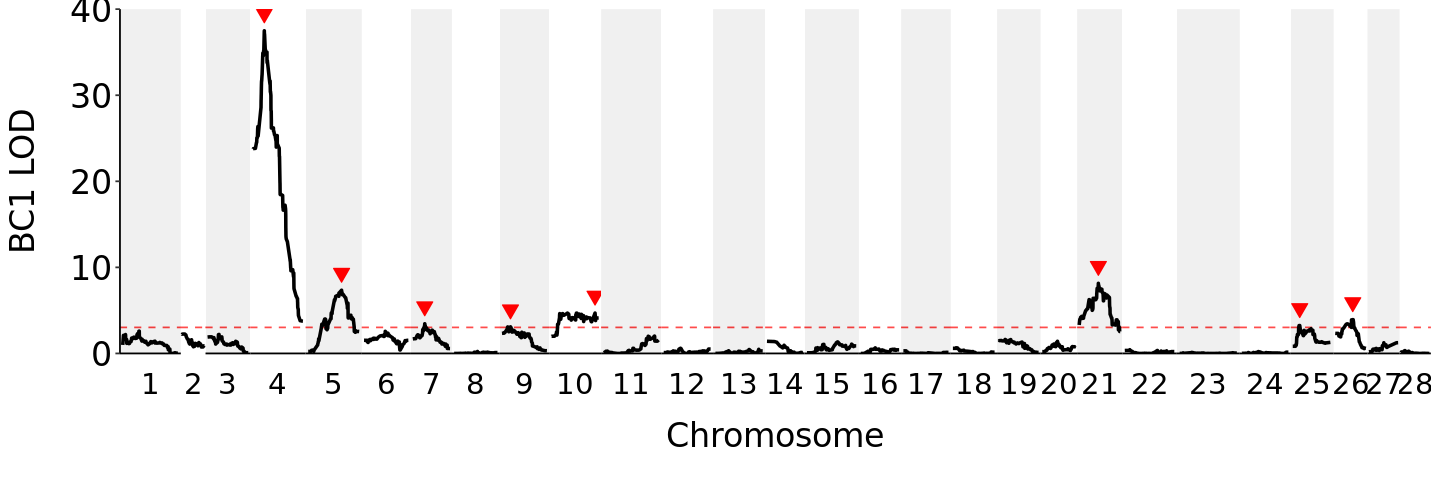

In [11]:
options(repr.plot.width=12, repr.plot.height=4)

p<-ggplot(chr_regions, aes(x = pos)) +
  geom_hline(yintercept=perm_thres, color="red", lty="dashed")+
  geom_rect(aes(xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf, fill = color), alpha = 0.3) +

  geom_point(data=lod_for_fit_top, aes(x=pos, y=lod+2),shape = 25, size=3, fill="red", color="red")+
  xlab("Chromosome")+
  ylab("BC1 LOD")+
  geom_line(data = out.hk.df, aes(x = pos, y = lod, group = chr), size=1) +
  facet_grid(. ~ chr, space = "free", scales = "free", switch = "x") +
  scale_x_continuous(breaks = c(1e7, 2e7, 3e7), labels=c(1, 2, 3)) +
  scale_fill_identity() +
    theme_bw()+
scale_y_continuous(limits = c(0, 40), expand = c(0, 0)) +
  theme(panel.spacing = unit(0, "lines"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
       axis.text.x=element_blank(),
    axis.title.y = element_text(vjust = 1, size = 20, margin = margin(10, 20, 10, 0), colour = "black"),
    axis.title.x = element_text(vjust = 1, margin = margin(10, 20, 10, 0), size = 20, colour = "black"),
    strip.text.x = element_text(size = 17.5, colour = "black"),
    axis.text.y = element_text(size = 20, colour = "black"),
    plot.title = element_text(face = "bold"),
         axis.ticks.x=element_blank(),
       strip.background = element_blank(),  
        strip.placement = "outside",
        panel.border = element_blank(), 
        axis.line = element_line())

print(p)

## Figure 2C Plot
BC1 Geno x Pheno Plot + Effect Sizes

In [12]:
# Extract Genotype x Phenotype data for QTL Peaks from Cross

geno_data <- as.data.frame(pull.geno(cross)[,rownames(lod_for_fit)])
geno_data[geno_data=="1"]<-"mori:mori"
geno_data[geno_data=="2"]<-"mori:mand"
geno_data[geno_data=="3"]<-"mand:mand"
geno_data$id<-cross$pheno$id
geno_data$length<-cross$pheno$length

geno_data_melt<-melt(geno_data, id.vars=c("id", "length"))
geno_data_melt$chr<-gsub("Bomo_Chr", "", stringr::str_split_fixed(geno_data_melt$variable, ":", 2)[,1])
geno_data_melt<-geno_data_melt[which(geno_data_melt$value!="NA"),]

# Extract Genotype x Phenotype data combining Top 3 QTL Peaks
geno_data$Chr4_5_21<-paste0(geno_data$`Bomo_Chr4:4272201`, "-",
                            geno_data$`Bomo_Chr5:12478648`, "-",
                            geno_data$`Bomo_Chr21:7151921`)
geno_data.all3<-geno_data[which(geno_data$Chr4_5_21=="mori:mori-mori:mori-mori:mori" | 
                                geno_data$Chr4_5_21=="mori:mand-mori:mand-mori:mand"),]
geno_data.all3.melt<-melt(geno_data.all3[,c("Chr4_5_21", "id", "length")], id.vars=c("id", "length"))
geno_data.all3.melt$value[which(geno_data.all3.melt$value=="mori:mand-mori:mand-mori:mand")]<-"mori:mand"
geno_data.all3.melt$value[which(geno_data.all3.melt$value=="mori:mori-mori:mori-mori:mori")]<-"mori:mori"
geno_data.all3.melt$chr<-"all three QTLs"

geno_data_melt$chr<-paste0("Chr ", geno_data_melt$chr)
geno_data_melt<-rbind(geno_data_melt, geno_data.all3.melt)
geno_data_melt$value<-factor(geno_data_melt$value, levels=c("mori:mori", "mori:mand", "mand:mand"))

# Extract Genotype x Phenotype data for Non Chr 4, 5, and 21 Peaks

geno_data_melt_remaining<-geno_data_melt[-which(geno_data_melt$chr %in% c("Chr 4", "Chr 21", "Chr 5", "all three QTLs")),]
geno_data_melt_remaining$chr<-factor(geno_data_melt_remaining$chr, levels=c("Chr 7", "Chr 9", "Chr 10", "Chr 25", "Chr 26"))
colnames(geno_data_melt_remaining)<-c("id", "length", "marker", "genotype", "chr")

# Extract Genotype x Phenotype data for Chr 4, 5, and 21 Peaks

geno_data_melt<-geno_data_melt[which(geno_data_melt$chr %in% c("Chr 4", "Chr 21", "Chr 5", "all three QTLs")),]
geno_data_melt$chr<-factor(geno_data_melt$chr, levels=c("Chr 4", "Chr 21", "Chr 5", "all three QTLs"))
colnames(geno_data_melt)<-c("id", "length", "marker", "genotype", "chr")

In [13]:
# Get Corresponding Phenotype Data from Cross
pheno_corrected<-as.data.frame(cross$pheno)
pheno_corrected$sex<-as.factor(pheno_corrected$sex)

# Correct Caudal Horn Length by regressing on Sex and Weight
model <- lm(length ~ weight + sex, data = pheno_corrected)
pheno_corrected$sex<-as.numeric(as.character(pheno_corrected$sex))

beta_weight<-model$coefficients[2]
beta_sex<-model$coefficients[3]
pheno_corrected$corr_len <- pheno_corrected$length - ((beta_weight*pheno_corrected$weight)-mean((beta_weight*pheno_corrected$weight)))-
((beta_sex*pheno_corrected$sex)-mean((beta_sex*pheno_corrected$sex)))


geno_data_melt$corr_length<-pheno_corrected$corr_len[match(geno_data_melt$id, pheno_corrected$id)]
head(geno_data_melt)

geno_data_melt_remaining$corr_length<-pheno_corrected$corr_len[match(geno_data_melt_remaining$id, pheno_corrected$id)]

,id,length,marker,genotype,chr,corr_length
,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,indiv2002,1.956674,Bomo_Chr4:4272201,mori:mand,Chr 4,2.115382
2,indiv2004,1.736989,Bomo_Chr4:4272201,mori:mori,Chr 4,1.867020
3,indiv2006,1.501522,Bomo_Chr4:4272201,mori:mori,Chr 4,1.549618
4,indiv2007,2.412518,Bomo_Chr4:4272201,mori:mand,Chr 4,2.283101
5,indiv2009,2.041476,Bomo_Chr4:4272201,mori:mand,Chr 4,1.862897
6,indiv2012,1.702795,Bomo_Chr4:4272201,mori:mand,Chr 4,1.671700


In [14]:
length_avg<-aggregate(corr_length~marker+genotype+chr, data=geno_data_melt, median)
length_avg<-dcast(length_avg, marker + chr ~ genotype, value.var = "corr_length")
length_avg$Pdiff<-(length_avg$`mori:mand`-length_avg$`mori:mori`)/(3.51 - 0.94)
length_avg


# Get QTL Model Estimates
chr_pve<-as.data.frame(summary(out.fq)$ests)
chr_pve<-chr_pve[order(chr_pve$est, decreasing=TRUE),]
chr_pve$chr<-paste0("Chr ", str_split_fixed(rownames(chr_pve), "@", 2)[,1])
chr_pve<-chr_pve[which(chr_pve$chr %in% c("Chr 4", "Chr 21", "Chr 5")),]
chr_pve<-plyr::rbind.fill(chr_pve, data.frame(est=sum(chr_pve$est), chr="all three QTLs"))
               
chr_pve$est_norm_mori<-chr_pve$est/length_avg$`mori:mori`[match(chr_pve$chr, length_avg$chr)]
chr_pve$chr<-factor(chr_pve$chr, levels=c("Chr 4", "Chr 21", "Chr 5", "all three QTLs"))

marker,chr,mori:mori,mori:mand,Pdiff
<fct>,<fct>,<dbl>,<dbl>,<dbl>
Bomo_Chr4:4272201,Chr 4,1.610970,1.900307,0.11258255
Bomo_Chr5:12478648,Chr 5,1.677584,1.805064,0.04960299
Bomo_Chr21:7151921,Chr 21,1.689655,1.837932,0.05769523
Chr4_5_21,all three QTLs,1.408154,2.102266,0.27008258


In [15]:
box_width <- 0.75

medians_df2 <- geno_data_melt %>%
  group_by(chr, genotype) %>%
  summarise(median_length = median(corr_length, na.rm = TRUE), .groups = "drop")


medians_edges2 <- medians_df2 %>%
  mutate(xpos = ifelse(genotype == unique(genotype)[1],
                       as.numeric(factor(genotype)) + box_width/2,  # right edge of left box
                       as.numeric(factor(genotype)) - box_width/2))



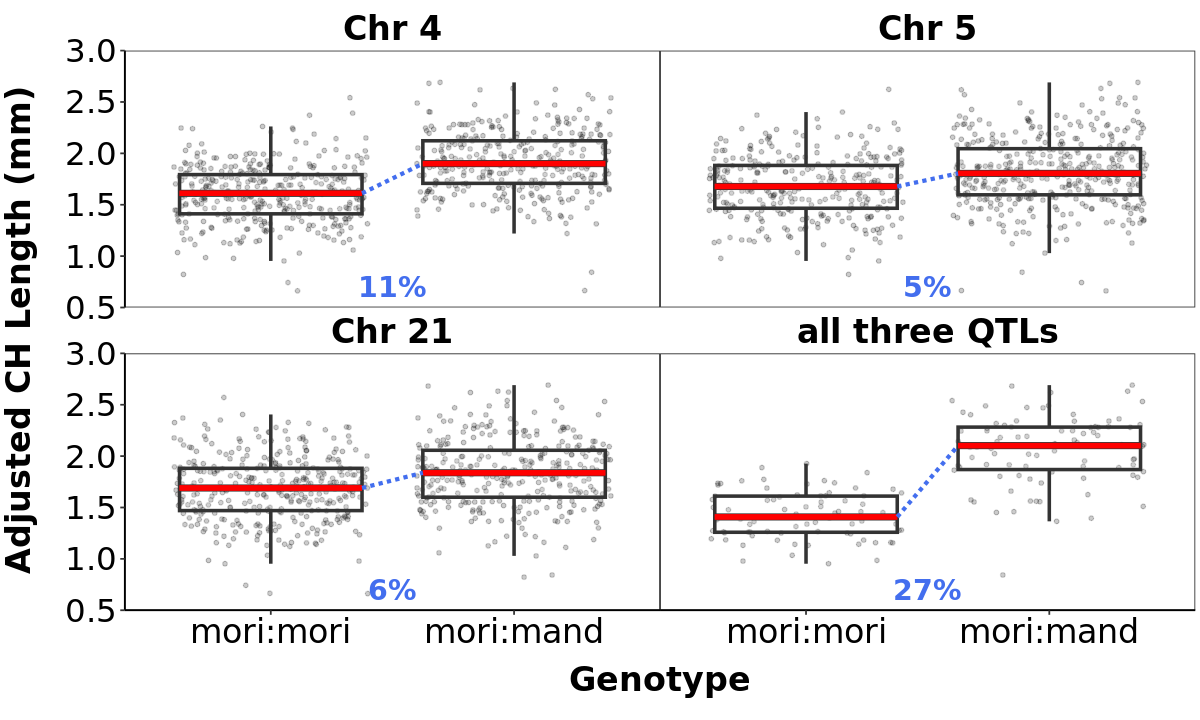

In [16]:
geno_data_melt$chr<-factor(geno_data_melt$chr, levels=c("Chr 4", "Chr 5", "Chr 21", "all three QTLs"))

options(repr.plot.width=10, repr.plot.height=6)


fig2c<-ggplot(geno_data_melt, aes(x = genotype, y = corr_length)) +
  geom_jitter(size = 1, alpha = 0.2) +
  geom_boxplot(size = 1, alpha=0.1, outlier.shape=NA) +
  stat_summary(fun = median, geom = "errorbar", 
               aes(ymax = ..y.., ymin = ..y..), 
               width = 0.75, color = "red", size = 1.5) + 
geom_text(data=length_avg, aes(x=1.5, y=0.7, label=paste0(round(Pdiff*100), "%")), color = "royalblue2", size=6, fontface = "bold")+
geom_line(data = medians_edges2,
            aes(x = xpos, y = median_length, group = chr),
            colour = "royalblue2", size = 1.2, linetype = "11", inherit.aes = FALSE) +
scale_y_continuous(limits=c(0.5, 3), breaks=seq(0.5,3, .5), expand=c(0,0))+
  theme_bw() +
  theme(
    axis.line = element_line(colour = "black"),
    text = element_text(size = 12),
    legend.position = "bottom",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_blank(),
    panel.spacing = unit(0, "lines"),
    axis.title.y = element_text(vjust = 1, face = "bold", size = 20, margin = margin(10, 20, 10, 0), colour = "black"),
    axis.title.x = element_text(vjust = 1, margin = margin(10, 20, 10, 0), face = "bold", size = 20, colour = "black"),
    axis.text.x = element_text(size = 20, colour = "black"),
    strip.text = element_text(size = 20, colour = "black", face="bold"),
    axis.text.y = element_text(size = 19.5, colour = "black"),
    plot.title = element_text(face = "bold"), plot.margin = unit(c(0.1, 0.1, 0.1, 0.1), "cm")
  ) +
  labs(x = "Genotype", y = "Adjusted CH Length (mm)")+facet_wrap(.~chr, ncol=2)
print(fig2c)



## Figure 2D Plot

Chr4 QTL Zoom-in

In [17]:
chr4<-out.hk.df[which(out.hk.df$chr=="4" & out.hk.df$pos>3990000 & out.hk.df$pos < 4800000),]
chr4$facet<-"A"

In [18]:
# Load Supp Table S3 File 
gene_list<-read.csv(file = "Supp_Table_S3.csv")

gene_list_for<-gene_list[which(gene_list$End>gene_list$Start),]
gene_list_rev<-gene_list[which(gene_list$End<gene_list$Start),]
gene_list$Direction<-ifelse(gene_list$Strand=="+", "TRUE", "FALSE")
gene_list$Color<-rep(c("black", "grey"), nrow(gene_list)/2)
gene_list$Color[grep("Wnt", gene_list$Gene.Model)]<-"orange"
gene_list$genename<-gsub(")", "", stringr::str_split_fixed(gene_list$Gene.Model, "[(]", 2)[,2])
gene_list<-gene_list[-nrow(gene_list),]
gene_list$facet<-"B"

In [19]:
# Chr4 Zoom-in
zoomin<- ggplot(chr4, aes(pos, lod))+
geom_line()+
geom_vline(xintercept=c(4076110, 4668489), linetype="dashed")+theme_bw()+
  scale_x_continuous(breaks = seq(4e6, 4.7e6, 100000), labels=seq(4,4.7, .1), limits=c(4e6, 4.75e6))+
  scale_y_continuous(breaks = seq(34,38, 1), expand=c(0,0), limits=c(34.75,38)) +
    labs(y="LOD score", x="")+
    ggtitle("Chr 4") + 

  theme(panel.spacing = unit(0, "lines"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
       axis.text.x=element_blank(),
    axis.title.y = element_text(vjust = 1, face = "bold", size = 20, margin = margin(10, 20, 10, 0), colour = "black"),
    axis.title.x = element_text(vjust = 1, margin = margin(10, 20, 10, 0), face = "bold", size = 20, colour = "black"),
    plot.title = element_text(hjust = 0, face = "bold", size = 20),
    strip.text.x = element_text(size = 20, colour = "black"),
    axis.text = element_text(size = 20, colour = "black"),
       strip.background = element_blank(),  
        strip.placement = "outside",
        panel.border = element_blank(),  
        axis.line = element_line())

In [22]:
library(gggenes)

In [23]:
# Gene Structure in Chr4 Zoom-in

z_genes<-ggplot()+
    geom_hline(yintercept=0, color = "black")+ylim(c(-0.01, 0.01))+
  geom_text(data=gene_list, aes(x = (Start + End) / 2, y = 0.01, label = genename),
                        fontface = "bold.italic", color = "chocolate2", size = 5)+
  geom_gene_arrow(data=gene_list, aes(xmin = Start, xmax =End, y = 0, forward=Direction, fill = Color, colour = Color), 
                  arrowhead_height = unit(2*10, "mm"), 
                  arrowhead_width = unit(0.66*2, "mm"),arrow_body_height= unit(2*10, "mm"),
                  color="black")+
labs(x="Mbp")+
geom_vline(xintercept=c(4076110, 4668489), linetype="dashed")+
scale_color_manual(values=c("black", "black", "chocolate2"))+
scale_fill_manual(values=c("black", "black", "chocolate2"))+theme_bw()+
  scale_x_continuous(breaks = seq(4e6, 4.7e6, 100000), labels=seq(4,4.7, .1), limits=c(4e6, 4.75e6))+
guides(fill = "none", color = "none")+
  theme(panel.spacing = unit(0, "lines"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
       axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
    axis.title.y = element_blank(),
    axis.title.x = element_text(vjust = 1, margin = margin(10, 20, 10, 0), face = "bold", size = 20, colour = "black"),
    strip.text.x = element_text(size = 18, colour = "black"),
    axis.text = element_text(size = 20, colour = "black"),
    plot.title = element_text(face = "bold"),
        axis.line.y = element_blank(),
       strip.background = element_blank(),  
        strip.placement = "outside",
        panel.border = element_blank(),  
        axis.line = element_line())

In [24]:
library(patchwork)

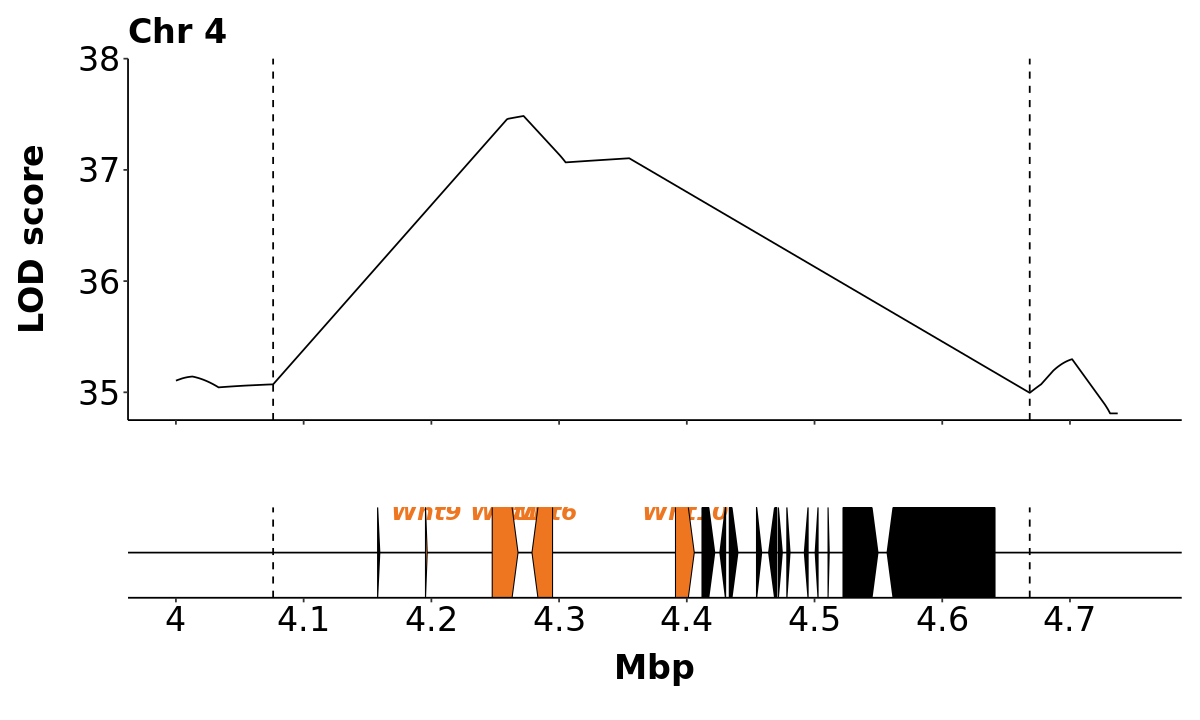

In [25]:
layout_design <- "
    A
    B
"

print(zoomin+z_genes+
  plot_layout(design = layout_design, 
              heights = c(0.8, 0.2)))

## Combined Fig2 Plot

Combine all subFigs into single page

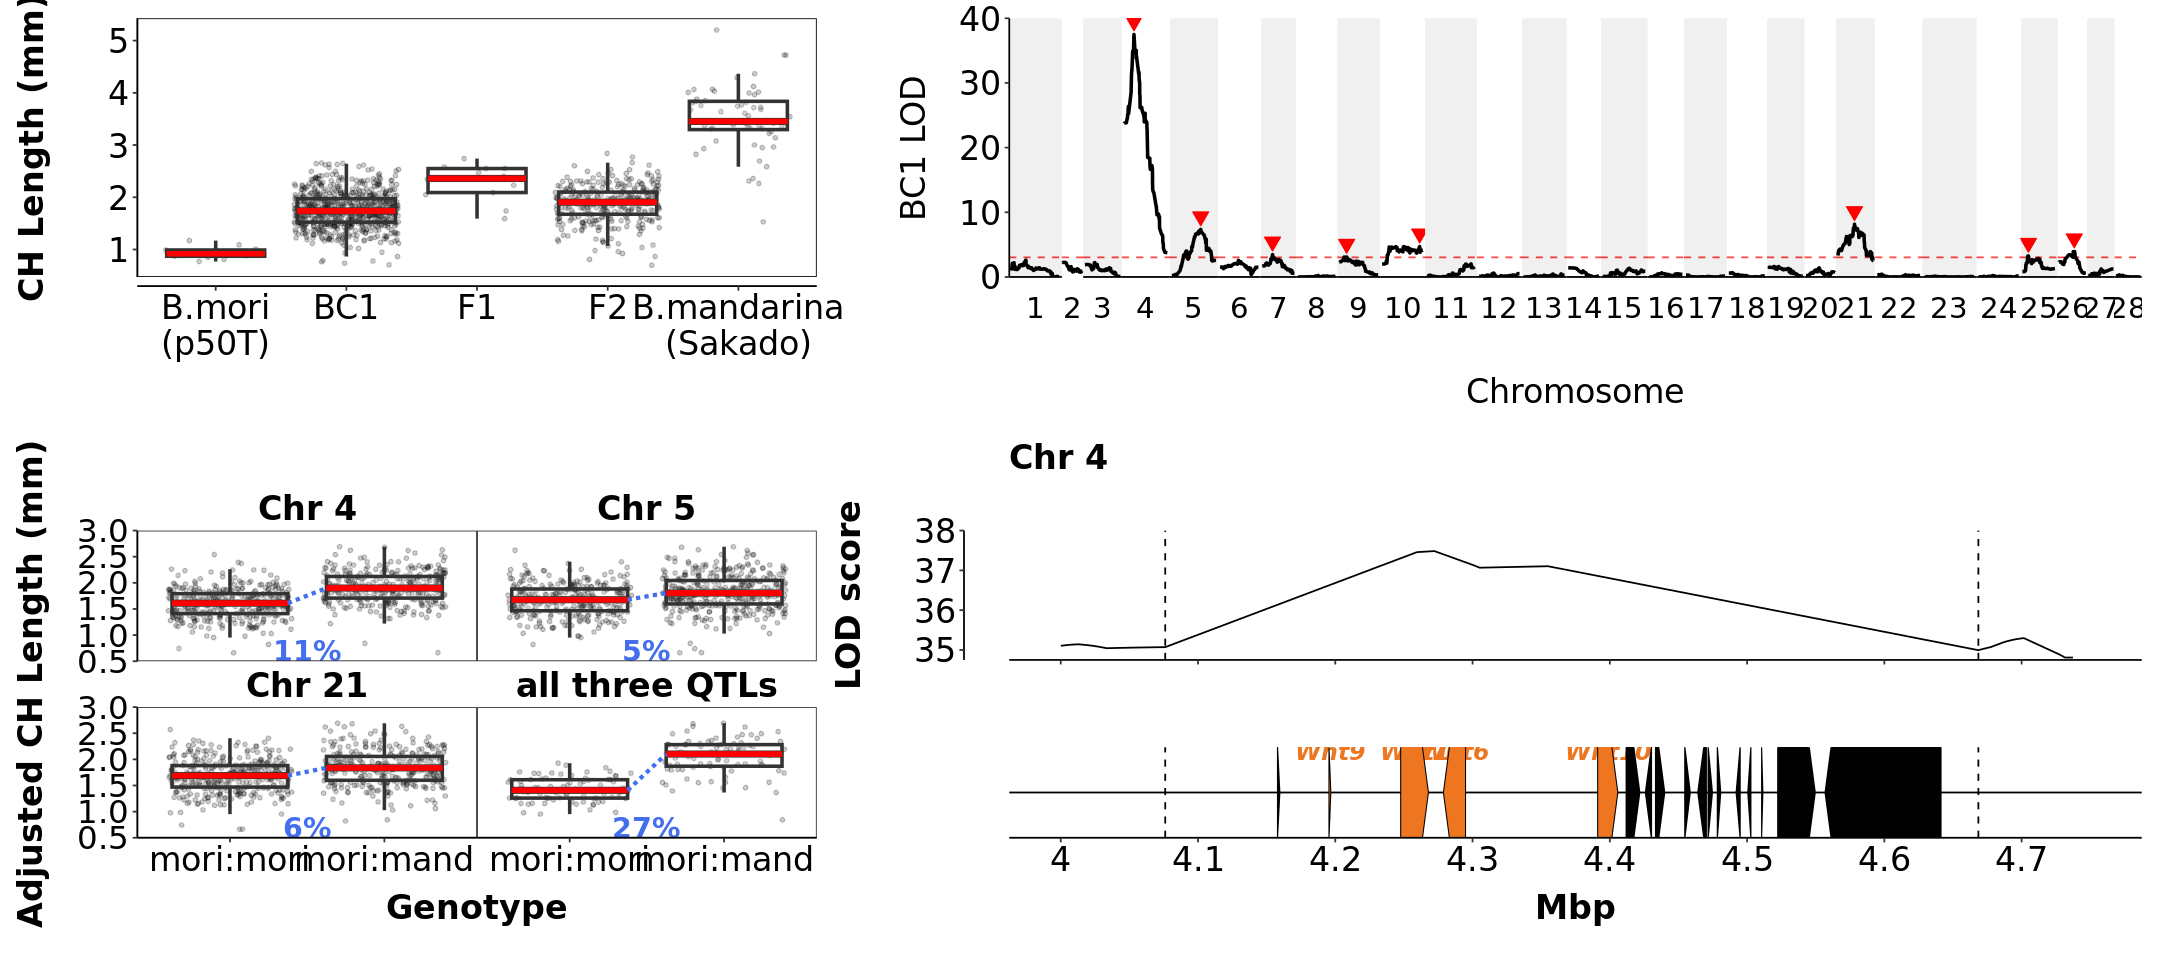

In [26]:
options(repr.plot.width=18, repr.plot.height=8)

layout_design <- "
    AAABBBBB
    AAABBBBB   
    AAABBBBB    
    AAABBBBB    
    CCCDDDDD
    CCCDDDDD
    CCCEEEEE
"
print(figa + p + fig2c + zoomin+z_genes + 
  plot_layout(design = layout_design, heights=c(0.7, 0.3)))